# A tour of PyCIEMSS interfaces and functionality

### Load dependencies and interfaces

In [1]:
import os
import pyciemss
import torch
import pandas as pd

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

smoke_test = ('CI' in os.environ)

### Select models and data

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type2_petrinet.json")
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
dataset2 = os.path.join(DATA_PATH, "traditional.csv")

### Set parameters for sampling

In [3]:
start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_samples = 3 if smoke_test else 10

## Sample interface
Take `num_samples` number of samples from the (prior) distribution invoked by the chosen model.

### Sample from model 1

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.619665,0.419648,0.136096,0.179665,0.019187,14.480751,0.105733,100.323349,6.386342,92.116547,59.724747,19339780.0,92.116547,100.323349,6.386342,0.105733
1,1,0,20.0,0.619665,0.419648,0.136096,0.179665,0.019187,14.480751,0.648129,389.862488,26.055084,358.446045,306.326721,19338954.0,358.446045,389.862488,26.055084,0.648129
2,2,0,30.0,0.619665,0.419648,0.136096,0.179665,0.019187,14.480751,2.777843,1515.915649,101.490646,1393.874756,1266.418091,19335742.0,1393.874756,1515.915649,101.490646,2.777843
3,3,0,40.0,0.619665,0.419648,0.136096,0.179665,0.019187,14.480751,11.061350,5890.290039,394.571838,5417.770508,4999.199707,19323322.0,5417.770508,5890.290039,394.571838,11.061350
4,4,0,50.0,0.619665,0.419648,0.136096,0.179665,0.019187,14.480751,43.243435,22825.574219,1531.948608,21020.025391,19495.595703,19275114.0,21020.025391,22825.574219,1531.948608,43.243435


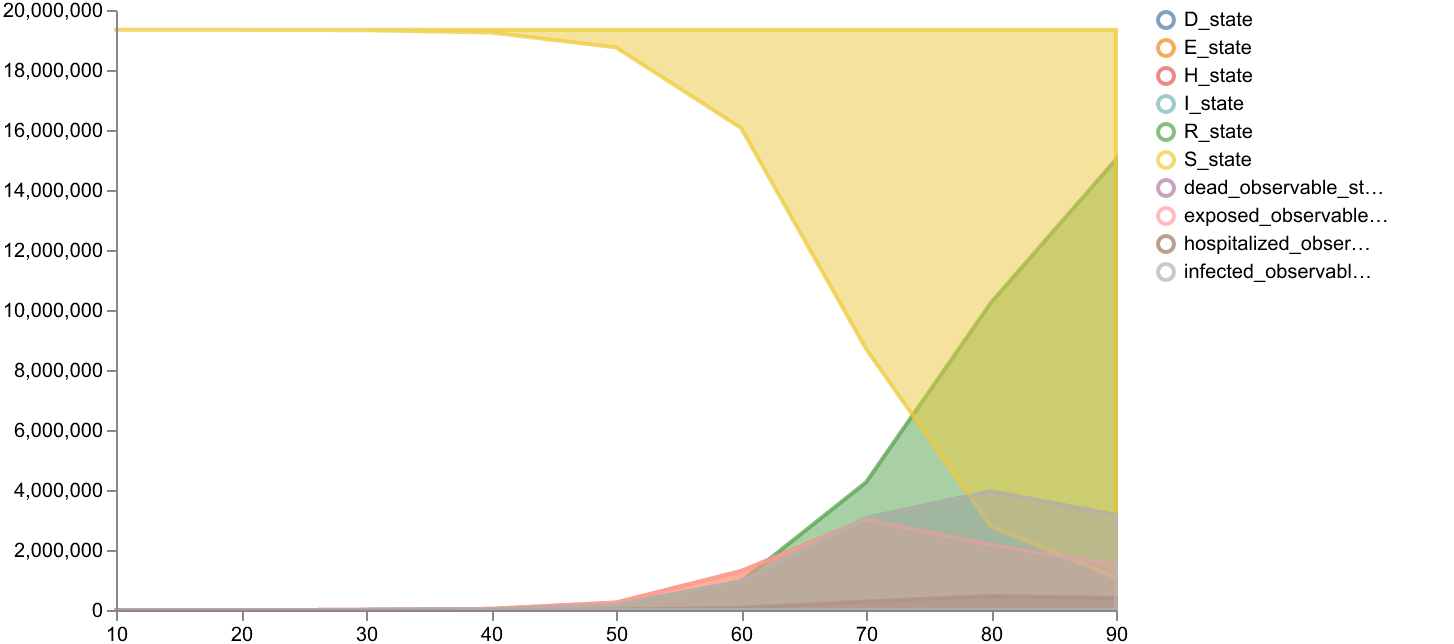

In [4]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Sample from model 2

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_beta_nc_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.656678,0.243576,0.303386,0.150732,0.188372,0.02591,7.414584,0.110601,45.481960,4.503936,49.097031,41.956341,19339896.0,49.097031,45.481960,4.503936,0.110601
1,1,0,20.0,0.656678,0.243576,0.303386,0.150732,0.188372,0.02591,7.414584,0.495105,100.334694,11.001494,108.960587,148.348862,19339668.0,108.960587,100.334694,11.001494,0.495105
2,2,0,30.0,0.656678,0.243576,0.303386,0.150732,0.188372,0.02591,7.414584,1.369731,222.112762,24.497990,241.216644,384.828644,19339164.0,241.216644,222.112762,24.497990,1.369731
3,3,0,40.0,0.656678,0.243576,0.303386,0.150732,0.188372,0.02591,7.414584,3.309145,491.670135,54.250927,533.974670,908.451904,19338042.0,533.974670,491.670135,54.250927,3.309145
4,4,0,50.0,0.656678,0.243576,0.303386,0.150732,0.188372,0.02591,7.414584,7.602705,1088.210571,120.088760,1181.923828,2067.541992,19335576.0,1181.923828,1088.210571,120.088760,7.602705


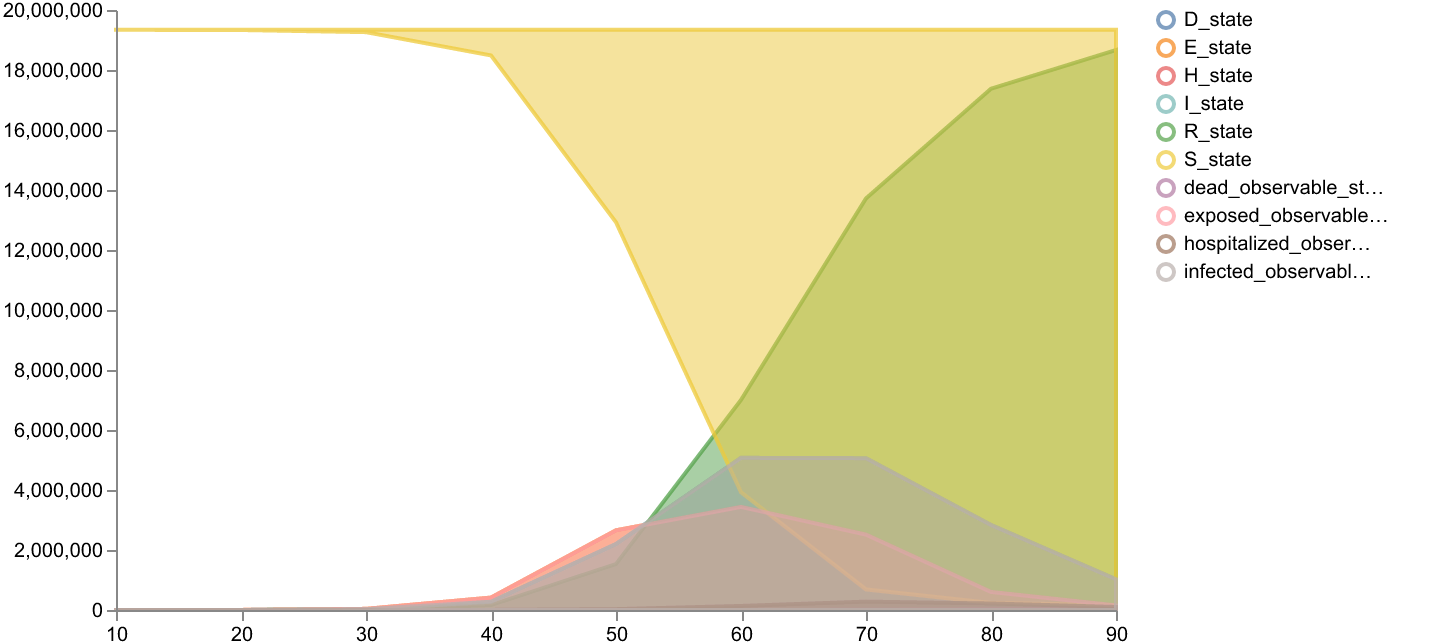

In [5]:
result2 = pyciemss.sample(model2, end_time, logging_step_size, num_samples, start_time=start_time)
display(result2['data'].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result2["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Ensemble Sample Interface
Sample from an ensemble of model 1 and model 2 

,timepoint_id,sample_id,timepoint_unknown,model_0/weight_param,model_1/weight_param,model_0/persistent_beta_c_param,model_0/persistent_kappa_param,model_0/persistent_gamma_param,model_0/persistent_hosp_param,model_0/persistent_death_hosp_param,...,D_state,E_state,H_state,I_state,R_state,S_state,infected_state,exposed_state,hospitalized_state,dead_state
0,0,0,10.0,0.710891,0.289109,0.515217,0.680212,0.196907,0.040739,0.098704,...,0.130458,112.633163,1.611078,73.063339,75.269974,19339762.0,73.063339,112.633163,1.611078,0.130458
1,1,0,20.0,0.710891,0.289109,0.515217,0.680212,0.196907,0.040739,0.098704,...,1.012343,735.331604,9.848248,475.504608,489.872223,19338326.0,475.504608,735.331604,9.848248,1.012343
2,2,0,30.0,0.710891,0.289109,0.515217,0.680212,0.196907,0.040739,0.098704,...,6.785410,4896.931641,65.216843,3167.137451,3224.198975,19328688.0,3167.137451,4896.931641,65.216843,6.785410
3,3,0,40.0,0.710891,0.289109,0.515217,0.680212,0.196907,0.040739,0.098704,...,45.192265,32465.849609,433.707703,21039.980469,21414.017578,19264650.0,21039.980469,32465.849609,433.707703,45.192265
4,4,0,50.0,0.710891,0.289109,0.515217,0.680212,0.196907,0.040739,0.098704,...,298.696808,207987.578125,2840.663818,136591.156250,140879.750000,18851454.0,136591.156250,207987.578125,2840.663818,298.696808


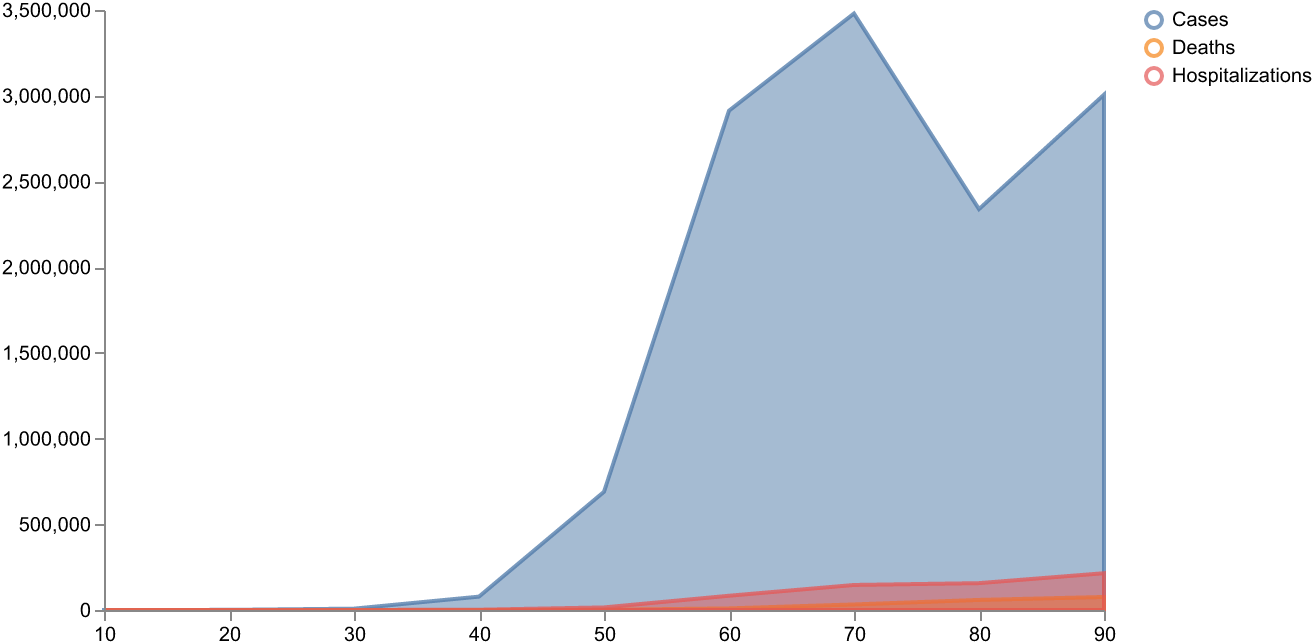

In [6]:
model_paths = [model1, model2]
solution_mappings = [lambda x : x, lambda x : x] # Conveniently, these two models operate on exactly the same state space, with the same names.

ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, logging_step_size, num_samples, start_time=start_time)
display(ensemble_result['data'].head())

# Plot the ensemble result for cases, hospitalizations, and deaths
nice_labels={"dead_state": "Deaths", 
                 "hospitalized_state": "Hospitalizations",
                 "infected_state": "Cases"
                }
schema = plots.trajectories(ensemble_result["data"], 
                           keep=["infected_state", "hospitalized_state", "dead_state"], 
                           relabel=nice_labels,
                          )
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Calibrate interface
Calibrate a model to a dataset by mapping model state varibales or observables to columns in the dataset. The `data_mapping` must be a dictionary where the keys are column names in the dataset, and the values are the state variables or observables they are mapped to (as in, `data_mapping = {"column_name": "observable/state_variable"}`).

In [7]:
data_mapping = {"case": "infected", "hosp": "hospitalized"} # data is mapped to observables
# data_mapping = {"case": "I", "hosp": "H"} # data is mapped to state variables

num_iterations = 10 if smoke_test else 1000
calibrated_results = pyciemss.calibrate(model1, dataset1, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
calibrated_results

Data printout: This dataset contains 2 rows of data. The first column, Timestamp, begins at 1.1 and ends at 3.3. The subsequent columns are named: case, hosp


{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 15.260611981153488}

In [8]:
parameter_estimates()

{'persistent_beta_c': tensor(0.1748, grad_fn=<ExpandBackward0>),
 'persistent_kappa': tensor(0.5473, grad_fn=<ExpandBackward0>),
 'persistent_gamma': tensor(0.4279, grad_fn=<ExpandBackward0>),
 'persistent_hosp': tensor(0.1243, grad_fn=<ExpandBackward0>),
 'persistent_death_hosp': tensor(0.0903, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(9.4274, grad_fn=<ExpandBackward0>)}

### Use calibrated parameter estimates in `sample` to sample from the calibrated model (posterior distr.)

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.553377,0.208436,0.432555,0.123797,0.045121,9.08499,0.181033,12.068603,2.707683,8.891654,51.392609,19339958.0,8.891654,12.068603,2.707683,0.181033
1,1,0,20.0,0.553377,0.208436,0.432555,0.123797,0.045121,9.08499,0.374054,4.637935,1.507971,3.439178,77.264107,19339970.0,3.439178,4.637935,1.507971,0.374054
2,2,0,30.0,0.553377,0.208436,0.432555,0.123797,0.045121,9.08499,0.466585,1.785938,0.643936,1.324392,87.621506,19339944.0,1.324392,1.785938,0.643936,0.466585
3,3,0,40.0,0.553377,0.208436,0.432555,0.123797,0.045121,9.08499,0.504684,0.687725,0.256526,0.509992,91.662018,19339944.0,0.509992,0.687725,0.256526,0.504684
4,4,0,50.0,0.553377,0.208436,0.432555,0.123797,0.045121,9.08499,0.519690,0.264827,0.099941,0.196386,93.225243,19339944.0,0.196386,0.264827,0.099941,0.519690


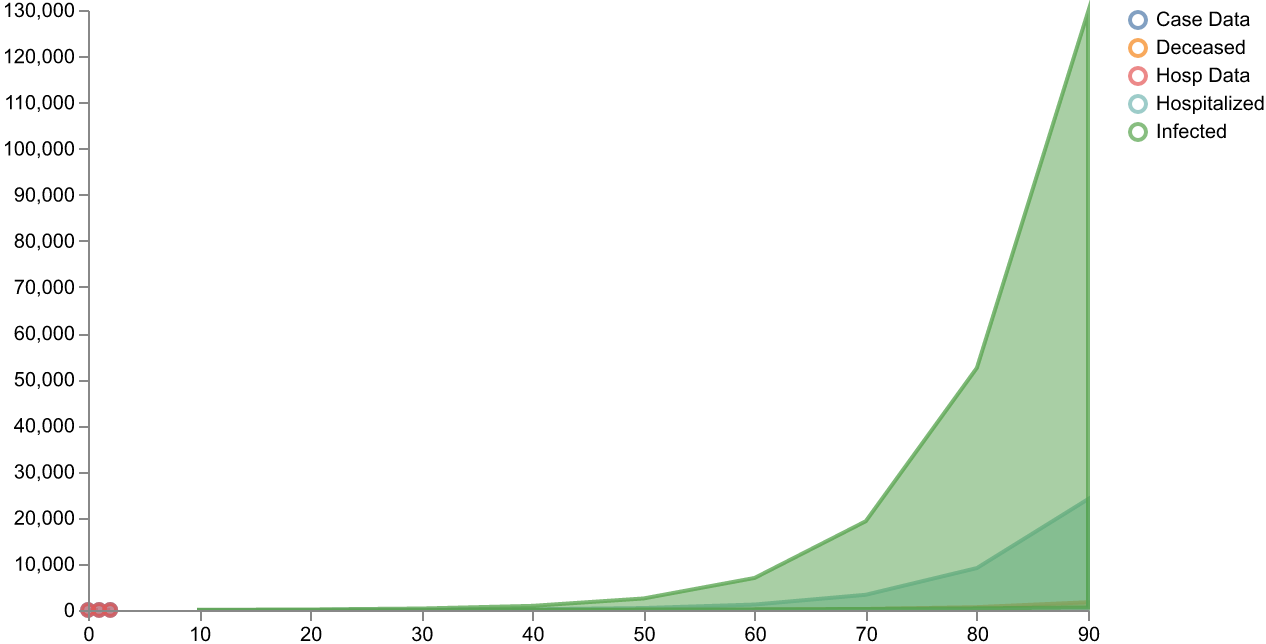

In [9]:
calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "dead_observable_state": "Deceased", 
        "hospitalized_observable_state": "Hospitalized",
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data",
        "hosp": "Hosp Data"
        }
data_df = pd.read_csv(dataset1)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state", "hospitalized_observable_state", "dead_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static parameter intervention
Change the value of the parameter `p_cbeta` to 0.5 on day 1

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:184: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return df.groupby("sample_id").apply(rework).reset_index(drop=True)


,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.5,11.435543,1.214630,0.096528,999.688843
1,1,0,2.0,0.5,11.435543,1.833385,0.227950,998.938599
2,2,0,3.0,0.5,11.435543,2.766056,0.426275,997.807129
3,3,0,4.0,0.5,11.435543,4.170294,0.725387,996.104553
4,4,0,5.0,0.5,11.435543,6.280804,1.176111,993.543213


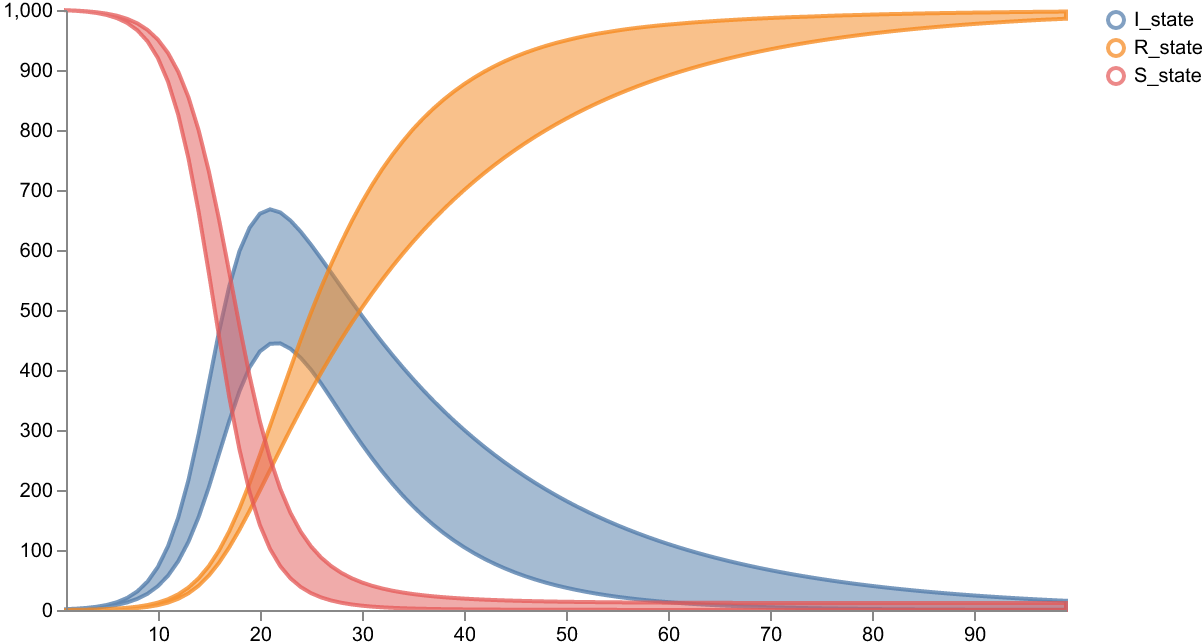

In [4]:
start_time = 0.0
end_time = 100.0
logging_step_size = 1.0
num_samples = 5 if smoke_test else 100

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={torch.tensor(1.): {"p_cbeta": torch.tensor(0.5)}})
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static state intervention
Change the Infected state `I` to 20.0 on day 5

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.440721,14.970421,1.452624,0.080979,999.466431
1,1,0,2.0,0.440721,14.970421,2.109517,0.198594,998.691833
2,2,0,3.0,0.440721,14.970421,3.062199,0.369360,997.568420
3,3,0,4.0,0.440721,14.970421,4.442460,0.617172,995.940247
4,4,0,5.0,0.440721,14.970421,6.439278,0.976528,993.584167


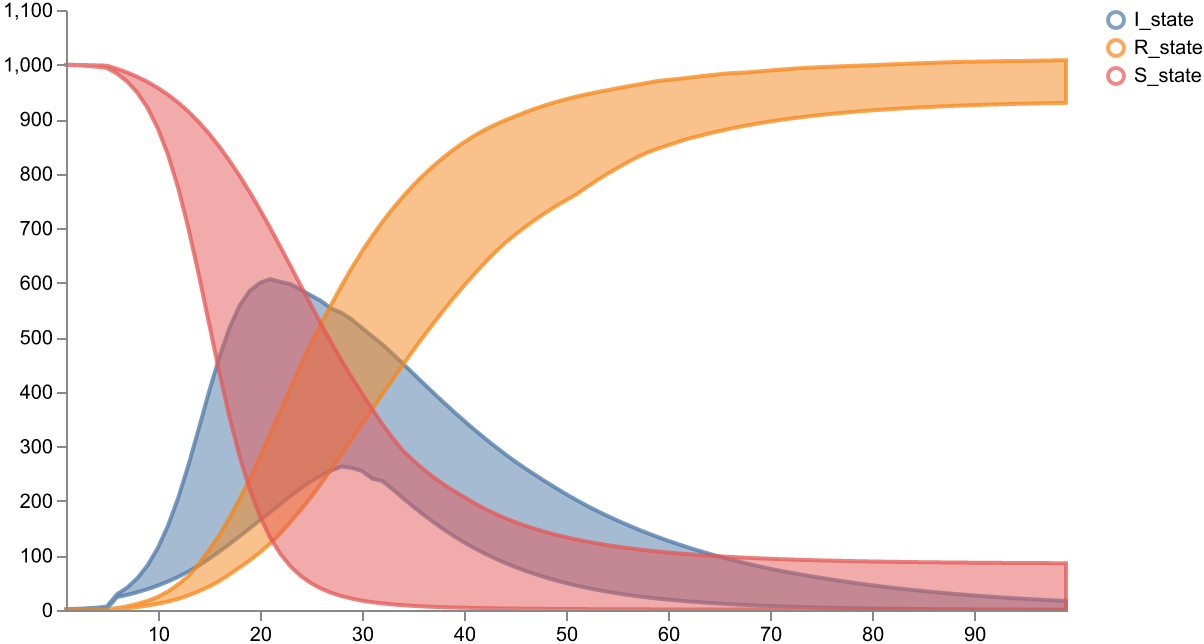

In [5]:
result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_state_interventions={torch.tensor(5.): {"I": torch.tensor(20.0)}}, solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with dynamic parameter interventions
Change the parameter `p_cbeta` from 0.35 to 0.3 when the infectious population `I` exceeds 400.

In [15]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    def var_threshold(time, state):
        return state[var] - threshold
    return var_threshold
    
infection_threshold = make_var_threshold("I", torch.tensor(400.0))
dynamic_parameter_interventions1 = {infection_threshold: {"p_cbeta": torch.tensor(0.3)}}

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_parameter_interventions=dynamic_parameter_interventions1, 
                         solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

ERROR:root:
                ###############################

                There was an exception in pyciemss

                Error occured in function: sample

                Function docs : 
    Load a model from a file, compile it into a probabilistic program, and sample from it.

    Args:
        model_path_or_json: Union[str, Dict]
            - A path to a AMR model file or JSON containing a model in AMR form.
        end_time: float
            - The end time of the sampled simulation.
        logging_step_size: float
            - The step size to use for logging the trajectory.
        num_samples: int
            - The number of samples to draw from the model.
        solver_method: str
            - The method to use for solving the ODE. See torchdiffeq's `odeint` method for more details.
            - If performance is incredibly slow, we suggest using `euler` to debug.
              If using `euler` results in faster simulation, the issue is likely that the model is s

KeyError: 'parameter_intervention_value_p_cbeta_0'

In [ ]:
# # NOTE: If you change the solver to "euler", you need to specify the step size in `solver_options` as below:
# # Specify solver options including the step_size
# solver_options = {"step_size": 1e-2}  # Example step size, adjust as needed
# result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
#                          dynamic_parameter_interventions=dynamic_parameter_interventions1, 
#                          solver_method="euler",
#                          solver_options=solver_options)

## Sample interface with dynamic state interventions
Reduce the susceptible population `S` to 200.0 when infections `I` exceed 400. 

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.38192,10.153263,1.327062,0.113840,999.559082
1,1,0,2.0,0.38192,10.153263,1.760752,0.264898,998.974548
2,2,0,3.0,0.38192,10.153263,2.335572,0.465296,998.199158
3,3,0,4.0,0.38192,10.153263,3.096991,0.731072,997.171997
4,4,0,5.0,0.38192,10.153263,4.104784,1.083412,995.811523


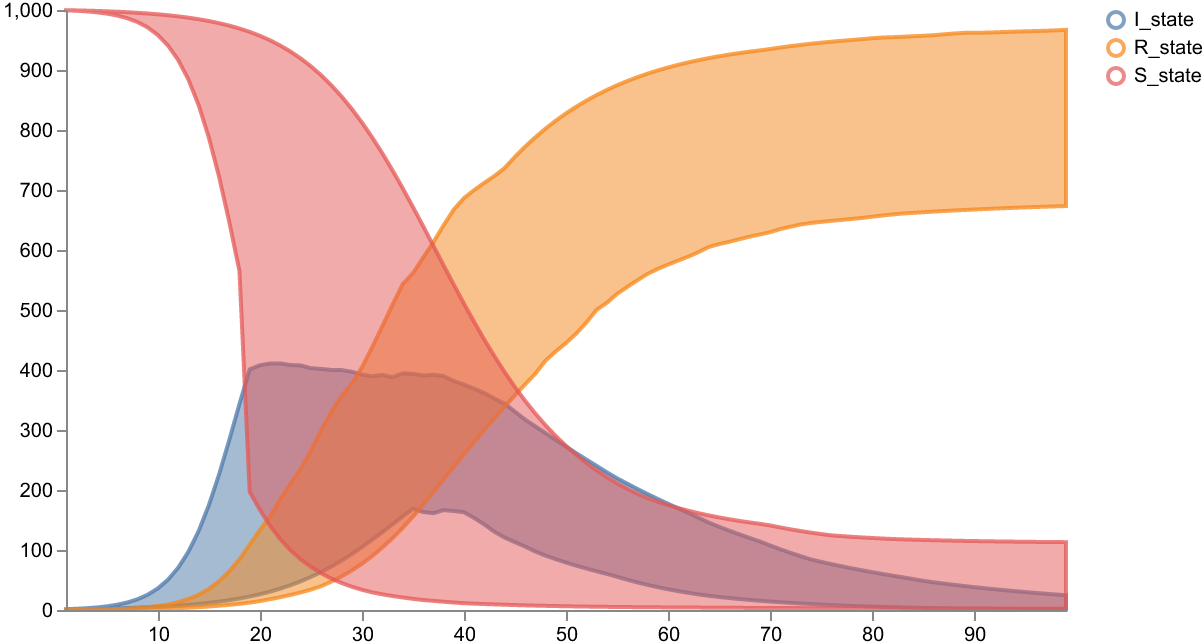

In [7]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    def var_threshold(time, state):
        return state[var] - threshold  
    return var_threshold
    
infection_threshold = make_var_threshold("I", torch.tensor(400.0))
dynamic_state_interventions1 = {infection_threshold: {"S": torch.tensor(200.0)}} 

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_state_interventions=dynamic_state_interventions1, 
                         solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Optimize interface
Get infections below 300 individuals at 100 days for SIR model with minimum change to current value for intervention parameter

In [8]:
import numpy as np
from typing import Dict, List
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)

start_time = 0.0
end_time = 40.0
logging_step_size = 1.0
observed_params = ["I_state"]
intervention_time = [torch.tensor(1.0)]
intervened_params = ["p_cbeta"]

In [9]:
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]

risk_bound = 300.0
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor([x])],
    start_time = intervention_time,
)
opt_result = pyciemss.optimize(
    model3,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=0.0,
    n_samples_ouu=int(1e2),
    maxiter=0,
    maxfeval=20,
    solver_method="euler",
)
print(f'Optimal policy:', opt_result["policy"])
print(opt_result)

 95%|█████████████████████████████████████████████▌  | 19/20 [00:18<00:00,  1.02it/s]

Optimal policy: tensor([0.3500], dtype=torch.float64)
{'policy': tensor([0.3500], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 9.999999999898979e-06
                          x: [ 3.500e-01]
                        nit: 1
      minimization_failures: 0
                       nfev: 19
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 9.999999999898979e-06
                                   x: [ 3.500e-01]
                                nfev: 19
                               maxcv: 0.0}


### Sample using the optimal policy as an intervention

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:184: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return df.groupby("sample_id").apply(rework).reset_index(drop=True)


,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.35,9.081274,1.238790,0.110117,999.651123
1,1,0,2.0,0.35,9.081274,1.535371,0.246528,999.218140
2,2,0,3.0,0.35,9.081274,1.902724,0.415598,998.681702
3,3,0,4.0,0.35,9.081274,2.357613,0.625120,998.017273
4,4,0,5.0,0.35,9.081274,2.920707,0.884732,997.194580


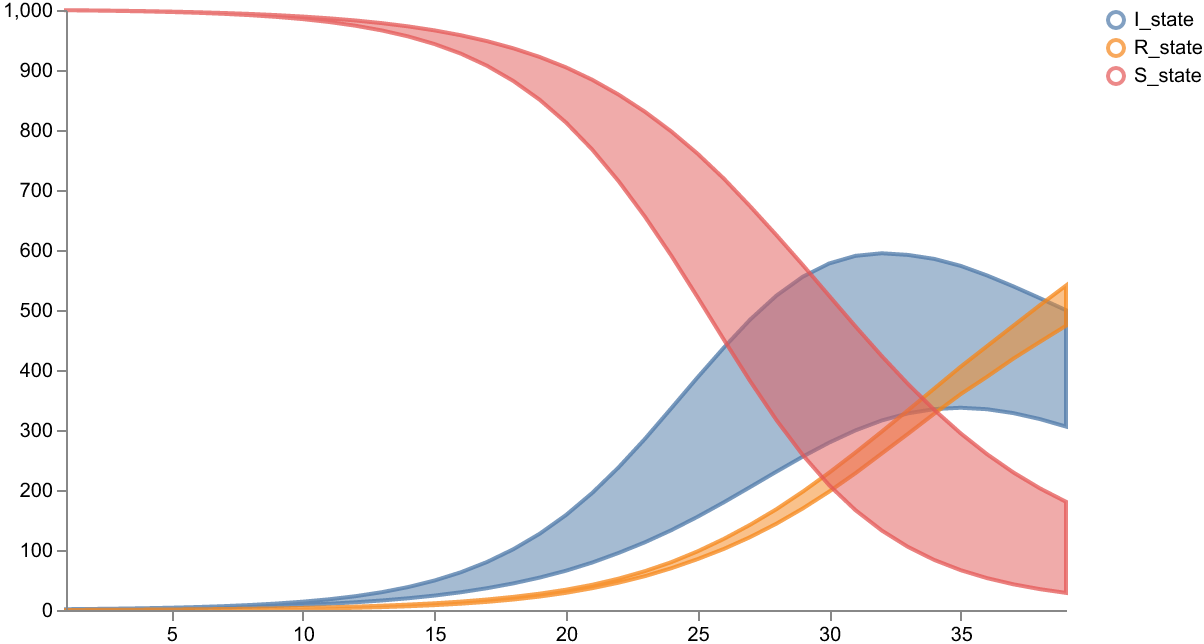

In [10]:
num_samples = 10 if smoke_test else 100
result = pyciemss.sample(
    model3,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result["policy"]),
    solver_method="euler",
)

display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Optimize interface for optimizing start time

In [11]:
initial_guess_interventions = 0.0
bounds_interventions = [[start_time], [end_time]]

risk_bound = 300.0
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
objfun = lambda x: -x

static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = torch.tensor([0.15]),
)
opt_result = pyciemss.optimize(
    model3,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=0.0,
    n_samples_ouu=int(1e2),
    maxiter=1,
    maxfeval=2,
    solver_method="euler",
)

print(f'Optimal policy:', opt_result["policy"])
print(opt_result)

6it [00:05,  1.06it/s]                                                               

Optimal policy: tensor([9.1716], dtype=torch.float64)
{'policy': tensor([9.1716], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -9.171524094255794
                          x: [ 9.172e+00]
                        nit: 1
      minimization_failures: 2
                       nfev: 4
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: -9.171524094255794
                                   x: [ 9.172e+00]
                                nfev: 2
                               maxcv: 0.0}


### Sample with the intervention implemented at the optimal time

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:184: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return df.groupby("sample_id").apply(rework).reset_index(drop=True)


,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.349256,9.081274,1.238790,0.110117,999.651123
1,1,0,2.0,0.349256,9.081274,1.534450,0.246528,999.219055
2,2,0,3.0,0.349256,9.081274,1.900443,0.415497,998.684082
3,3,0,4.0,0.349256,9.081274,2.353377,0.624767,998.021851
4,4,0,5.0,0.349256,9.081274,2.913716,0.883913,997.202393


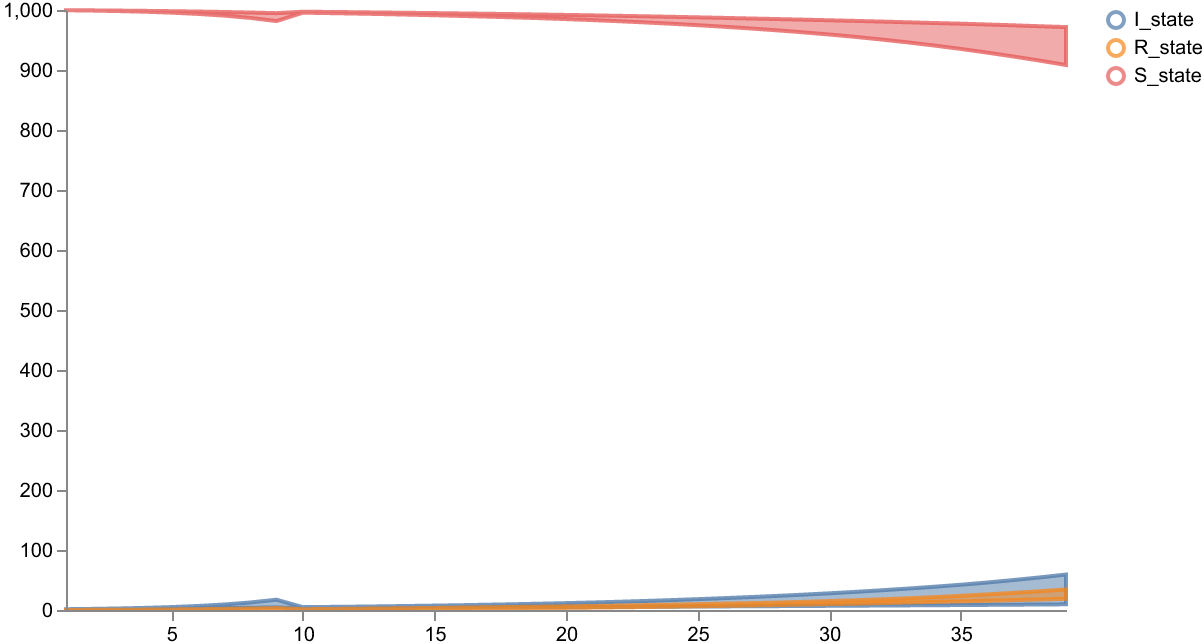

In [12]:
num_samples = 10 if smoke_test else 100
result = pyciemss.sample(
    model3,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result["policy"]),
    solver_method="euler",
)

display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)